In [2]:
import torch
import pandas as pd
import seaborn as sns
import math
import torch
from torch import nn 
import tqdm

from  utils import * 


# Defintions 

In [4]:

def run_experiments(configs, for_matrix='G'):
    df = []
    for c,c_dict in tqdm.tqdm(list(dict_configs(configs,return_dict=True))):
        try:
            if c.gain=='xavier':
                gain = torch.nn.init.calculate_gain(c.activation)
            else:
                gain = c.gain
            input = create_input(n=c.n, d=c.d, degeneracy=c.degeneracy,dist='norm')
            F = get_activation_function(c.activation)
            c0, c1, csum2, beta = act_info(c.activation)
            c_dict.update(dict(c0=c0, c1=c1, csum2=csum2, beta=beta))
            X = input
            stats = calc_stats(X)
            df.append({**c_dict, **stats,
                       'l': 0, 
                       'layer': 'input',})

            # X = X - X.mean(dim=1,keepdim=True)
            X = X / (X**2).mean(dim=1,keepdim=True)**0.5
            for l in range(c.L):
                W = torch.randn(c.d,c.d) * gain  / np.sqrt(c.d)
                if c.activation_first:
                    X = X @ W + c.bias
                    X = F(X) 
                else:
                    X = F(X)
                    X = X @ W + c.bias 

                if for_matrix=='G':
                    stats = calc_stats(X)
                else:
                    stats = calc_stats(X.t())
                df.append({**c_dict, **stats,
                           'l': l+1, 
                           'layer': 'pre_norm',})
                means, norms, norm_var = torch.Tensor([0]), torch.Tensor([1]),torch.Tensor([0])
                if c.centering=='MF':
                    means =  torch.Tensor([c0])
                elif c.centering=='layer':
                    means = X.mean(dim=1,keepdim=True)
                elif c.centering=='batch':
                    means = X.mean(dim=0,keepdim=True)
                elif c.centering=='None':
                    means = torch.Tensor([0])
                else:
                    raise ValueError(f"centering {c.centering} is not valid")
                X = X - means
                if  c.normalization=='MF':
                    norms = torch.Tensor([(csum2- c0**2)**0.5])
                elif c.normalization=='layer':
                    norms = (X**2).mean(dim=1,keepdim=True)**0.5
                    norm_var = (norms.var() / norms.mean() **2).item()
                elif c.normalization=='batch':
                    norms = (X**2).mean(dim=0,keepdim=True)**0.5
                    norm_var = (norms.var() / norms.mean() **2).item()
                elif c.normalization=='None':
                    norms = torch.Tensor([1])
                    pass
                else:
                    raise ValueError(f"normalization {c.normalization} is not valid")
                X = X / norms
                if for_matrix=='G':
                    stats = calc_stats(X)
                else:
                    stats = calc_stats(X.t())
                df.append({**c_dict,  **stats,
                           'l': l+1, 
                           'mean_avg': means.mean().item(),
                           'norm_avg': norms.mean().item(),
                           'norm_var':norm_var,
                           'layer': 'post_norm'})

        except Exception:
            pass
    df = pd.DataFrame(df)
    df[['gamma0','iso_gap0']] = df.merge(df.loc[(df.layer=='post_norm')&(df.l==1)], on=list(configs.keys()),how='left')[['gamma_y','iso_gap_y']]
    df['gamma_theory'] = df['gamma0']/ (df.beta ** df.l)
    df['iso_gap_theory'] = 2*c.n*df['gamma0']/ (df.beta ** df.l)
    return df


def plot_line_graph(data, y, y_label, file_name, show_legend=True, **kwargs):
    if 'height' not in kwargs:
        kwargs['height'] = 3
    plt.figure()
    sns.set_style('whitegrid')
    sns.set_context('paper', font_scale=1.5)  # Increase the font size
    g = sns.FacetGrid(data=data, **kwargs)
    g.map(sns.lineplot, "l", y, marker="o")
    g.set_ylabels(y_label, fontsize=14)  # Increase the font size for y-label
    g.set_xlabels("$\ell$", fontsize=14)  # Increase the font size for x-label
    if 'col' in kwargs:
        g.set_titles(" {col_name}", fontsize=14)  # Increase the font size for titles
    if 'hue' in kwargs:
        ncols = len(df[kwargs['hue']].unique())
        if show_legend:
            g.add_legend(title='',alignment='left', fontsize=14)  # Increase the font size for legend
            sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.05), ncols=ncols, frameon=False)
    plt.yscale('log')
    plt.savefig(file_name, bbox_inches="tight")
    plt.show()

    
# Define a function to create a line plot
def plot_line(data, y_var, y_label, file_name, **kwargs):
    plt.figure()
    sns.set_style('whitegrid')
    sns.set_context('paper', font_scale=1.5)  # Increase the font size
    g = sns.FacetGrid(data=data.loc[data.layer=='post_norm'], **kwargs)
    g.map(sns.lineplot, "l", y_var + "_theory", linestyle="dashed", color='k', label="theory")
    g.map(sns.lineplot, "l", y_var, linestyle="solid", label='empirical')
    g.add_legend(fontsize=14)  # Increase the font size for legend
    # sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.05), ncols=2, frameon=False)
    plt.yscale('log')
    g.set_ylabels(y_label, fontsize=14)  # Increase the font size for y-label
    g.set_xlabels("$\ell$", fontsize=14)  # Increase the font size for x-label
    g.set_titles("{col_name}", fontsize=14)  # Increase the font size for titles
    plt.savefig(file_name, bbox_inches="tight")
    plt.show()


# Numerical evaluation of Hermite coefficients and $\beta_0$
given activation $f:R\to R$, we have (up to some constant scale) $c_0 = E_{x\sim N(0,1)} f(x),c_1 = E_{x\sim N(0,1)} x f(x), $ and $\sum_{k=0}^\infty c_k^2 = E_{x\sim N(0,1)} f(x)^2,$ thus, $\beta_0$ can be quantified by sampling from Normal distribution and computing numerical averages for this expectations

In [3]:
dist = torch.distributions.normal.Normal(0, 1)  
samples = dist.sample((2000000,))
__act_info__ = dict()

def act_info(act,):
    if act not in __act_info__:
        F = get_activation_function(act)
        c0 = torch.mean(F(samples)).item()
        c1 = torch.mean(F(samples)*samples).item()
        csum2 = torch.mean(F(samples)**2).item() 
        beta = 2 - c1**2 / (csum2 - c0**2)
        __act_info__[act] = (c0, c1, csum2, beta)
    return __act_info__[act]

print(act_info('relu'))


F = get_activation_function('relu')
hermit_coefs(lambda x: np.sqrt(2)*np.max(x,0),n=10)

(0.3992559611797333, 0.5008248090744019, 0.5008248090744019, 1.265345127401392)


array([ 0.00000000e+00,  1.41421356e+00,  0.00000000e+00, -2.21457453e-17,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -5.62431626e-19,
        0.00000000e+00,  2.34346511e-20,  0.00000000e+00])

# Main figures

## Dual kernel of activatioin 

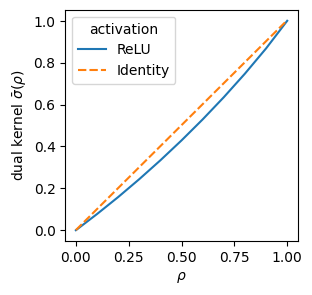

In [5]:
def dual_act(act, reduce_mean = True):
    a, b, c = torch.randn(3, 1000000)
    c0 = (act(a)).mean()
    csum2 = (act(a)**2).mean()
    reduce_mean = reduce_mean * 1
    F = lambda x: (act(x) - c0 * reduce_mean)/(csum2-reduce_mean * c0**2)**0.5
    rhos = torch.arange(0, 1.1, 0.1)
    dual = torch.empty_like(rhos)
    for i,rho in enumerate(rhos):
        x = a *(1-rho)**0.5 + c * rho**0.5
        y = b *(1-rho)**0.5 + c * rho**0.5
        dual[i] = (F(x) * F(y)).mean().item()
    return rhos, dual

df = []
for reduce_mean in [True]:
    for act in ['ReLU', 'Identity']:
        F = getattr(torch.nn, act)()
        rhos, dual = dual_act(F, reduce_mean=reduce_mean)
        for rho,rhohat in zip(rhos,dual):
            df.append({'activation': act, 'rho': rho.item(), 'rho_hat': rhohat.item(), 'reduce_mean': reduce_mean})
df = pd.DataFrame(df)
# g = sns.FacetGrid(df, col="reduce_mean", col_wrap=2, height=3.5, aspect=1,hue='activation')#, hue_order=activation_beta_df.activation, palette=palette_dict,)
# g.map(sns.lineplot, 'rho', 'rho_hat',)
ax = plt.figure(figsize=(3,3))
ax = sns.lineplot(df, x='rho', y='rho_hat', hue='activation',style='activation')
ax.set_xlabel('$\\rho$')
ax.set_ylabel('dual kernel $\\bar\\sigma(\\rho)$')
# ax.set(xlabel='$\\rho$', ylabel='dual kernel $\\bar\\sigma(\\rho)$')
plt.savefig('plots/dual_kernel_convexity.pdf', bbox_inches='tight')

plt.show()

## Isometry vs Hermite poly degree

100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


<Figure size 640x480 with 0 Axes>

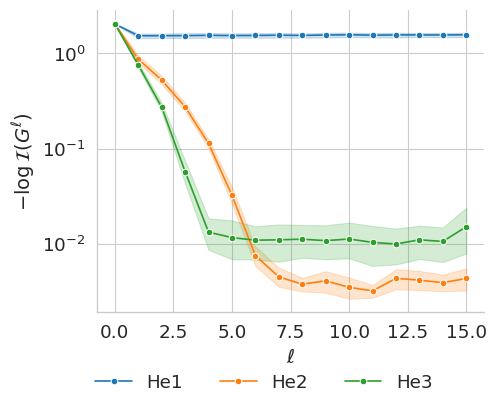

In [39]:

configs = dict(
    n = [10], # batch size 
    d = [2000], # width 
    L = [15], # depth
    activation_first = [True,],
    centering = ['layer'],
    normalization = ['layer',], # normalization layer
    activation = ['He1','He2','He3',], # activation function
    gain = [1.],
    bias = [0.],
    degeneracy = [10], # input degeneracy 
    for_matrix=['G'],
    rerun = range(10), # independent runs
)
df = run_experiments(configs)
df.head()


plot_line_graph(df, y="iso_gap", y_label="$-\log\mathcal{I}(G^\ell)$",aspect=1.25,
                hue = "activation",#hue="normalization",
                file_name='plots/ln_hermite_poly.pdf', height=4)


## Isometry vs. order of act-normalization layers

100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


<Figure size 640x480 with 0 Axes>

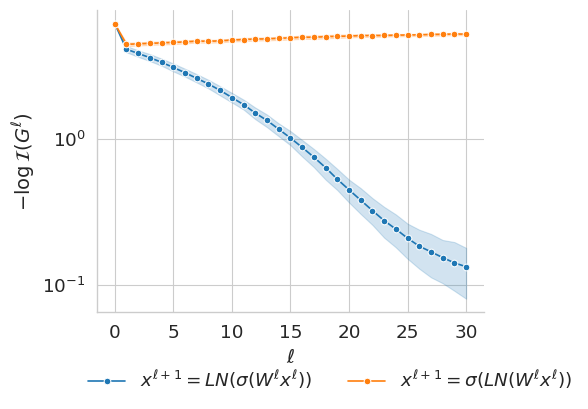

In [38]:


configs = dict(
    n = [10],
    d = [1000],
    L = [30],
    centering = ['layer'],
    normalization = ['layer',], # normalization layer
    activation_first = [True,False],
    activation = ['relu',],
    gain = [1.],
    bias = [0.],
    degeneracy = [100],
    for_matrix=['G'],
    repeat = range(10),
)
df = run_experiments(configs)
# df.head()
df['order'] = df.apply(lambda x: '$x^{\\ell+1} = LN(\\sigma(W^\\ell x^\\ell))$' if x.activation_first else '$x^{\\ell+1} = \\sigma(LN(W^\\ell x^\\ell))$', axis=1)
plot_line_graph(df, y="iso_gap", y_label="$-\log\mathcal{I}(G^\ell)$",
                hue="order",aspect=1.25,#hue="activation",
                file_name='plots/activation_first_order.pdf', height=4)



<Figure size 640x480 with 0 Axes>

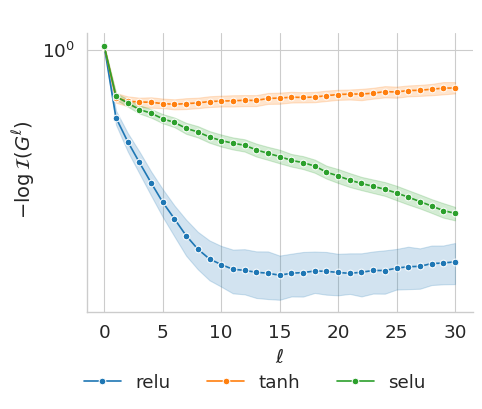

In [37]:
configs = dict(
    n = [10],
    d = [1000],
    L = [30],
    activation_first = [True,],
    centering = ['layer'],
    normalization = ['None',],
    activation = ['relu','tanh','selu'],
    gain = [1.],
    bias = [0.],
    degeneracy = [5],
    for_matrix=['G'],
    repeat = range(30),
)
# df = run_experiments(configs)
df.head()

df.loc[df.normalization=='None','normalization'] = ''
# df.loc[df.normalization=='layer', 'normalization'] = 'LayerNorm'

plot_line_graph(data=df, 
                y='iso_gap', y_label=" $-\log\mathcal{I}(G^\ell)$", 
                hue="activation",col="normalization", aspect=1.25,
                file_name='plots/self_normalize.pdf', height=4)




## Centering and Hermit expansion 

<Figure size 640x480 with 0 Axes>

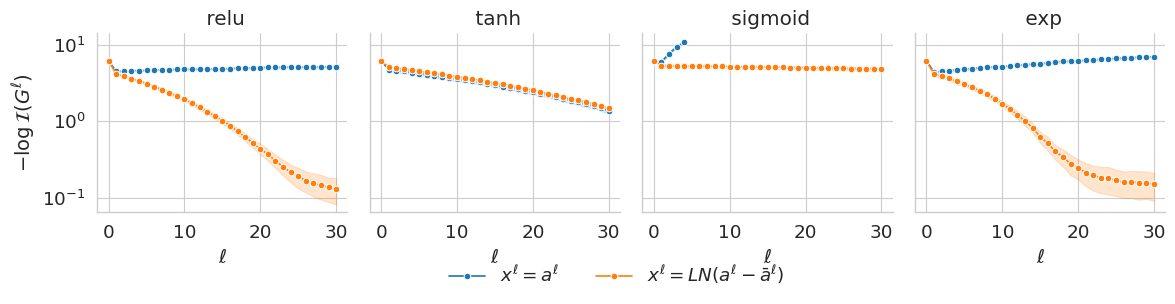

<Figure size 640x480 with 0 Axes>

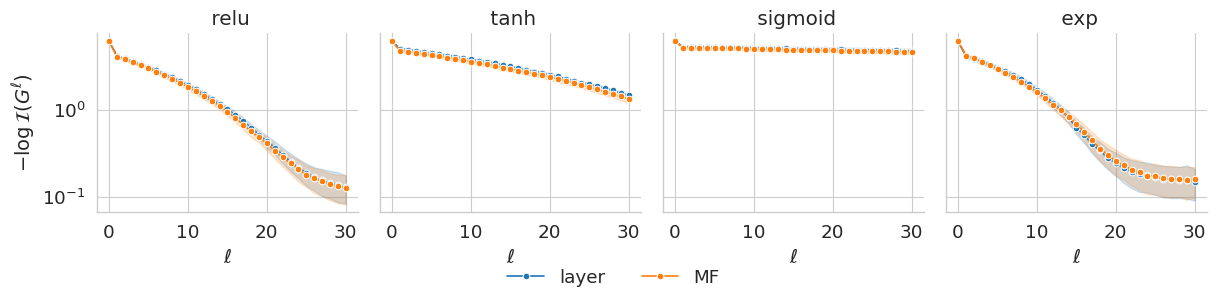

In [65]:

configs = dict(
    n = [10],
    d = [1000],
    L = [30],
    centering = ['None','layer','MF'],
    normalization = ['layer',],
    activation_first = [True,],
    activation = ['relu','tanh','sigmoid', 'exp'],
    gain = [1.],
    bias = [0.],
    degeneracy = [100],
    for_matrix=['G'],
    repeat = range(10),
)
df = run_experiments(configs)
centering2name = {'None': '$x^{\\ell} = a^\\ell$', 'layer': '$x^{\\ell} = LN(a^\\ell - {\\bar a}^\\ell$)', 'MF':  '$x^{\\ell} = LN(a^\\ell - c_0)$)'}
df['center'] = df.centering.map(lambda x: centering2name[x])
df.head()



plot_line_graph(df.loc[df.centering.isin(['None','layer'])], y="iso_gap", y_label="$-\log\mathcal{I}(G^\ell)$",
                hue="center",col="activation",show_legend=True, 
                file_name='plots/with_without_centering.pdf', )

plot_line_graph(df.loc[df.centering.isin(['MF','layer'])], y="iso_gap", y_label="$-\log\mathcal{I}(G^\ell)$",
                hue="centering",col="activation",show_legend=True,
                file_name='plots/layer_vs_meanfield_centering.pdf', )

## Normalization and Hermit expansion

100%|██████████| 120/120 [00:30<00:00,  3.94it/s]


<Figure size 640x480 with 0 Axes>

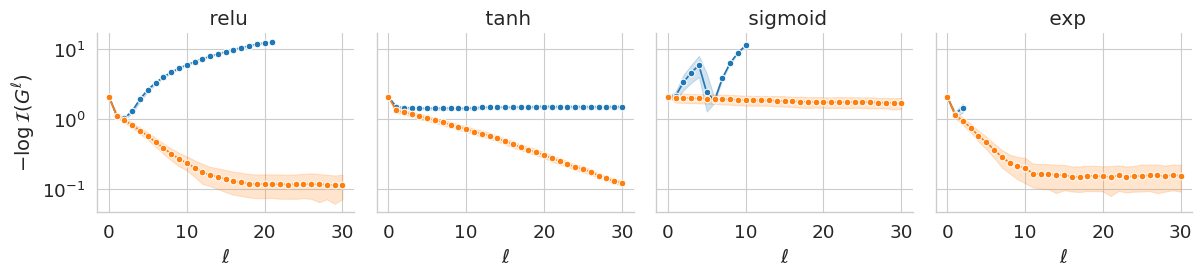

<Figure size 640x480 with 0 Axes>

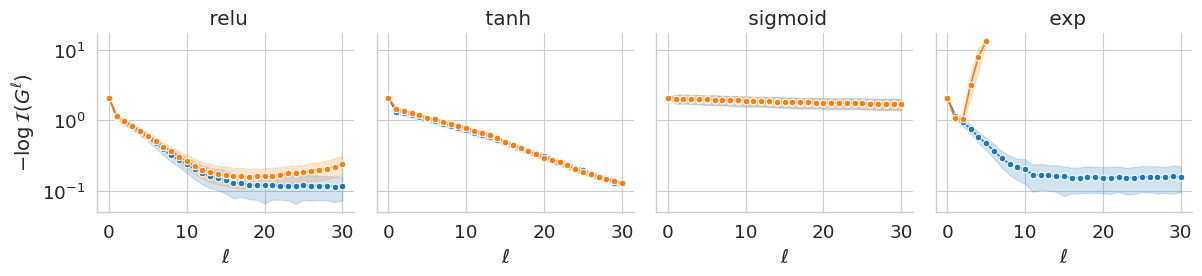

In [66]:

configs = dict(
    n = [10],
    d = [1000],
    L = [30],
    centering = ['MF'],
    normalization = ['None','layer','MF'],
    activation_first = [True,],
    activation = ['relu','tanh','sigmoid','exp'],
    gain = [1.],
    bias = [0.],
    degeneracy = [10],
    for_matrix=['G'],
    repeat = range(10),
)
df = run_experiments(configs)
df.head()



plot_line_graph(df.loc[df.normalization.isin(['None','layer'])], y="iso_gap", y_label="$-\log\mathcal{I}(G^\ell)$",
                hue="normalization",col="activation",show_legend=False,
                file_name='plots/with_without_projection.pdf', )

plot_line_graph(df.loc[df.normalization.isin(['MF','layer'])], y="iso_gap", y_label="$-\log\mathcal{I}(G^\ell)$",
                hue="normalization",col="activation",show_legend=False,
                file_name='plots/layer_vs_meanfield_projection.pdf', )

## Normalization’s role in stabilizing mean-field accuracy through depth

100%|██████████| 60/60 [00:08<00:00,  6.67it/s]


<Figure size 640x480 with 0 Axes>

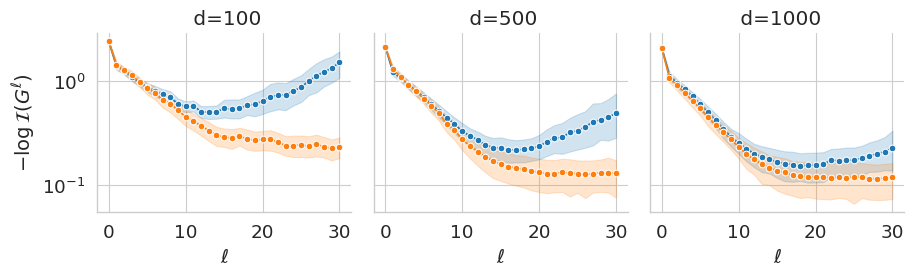

In [67]:

configs = dict(
    n = [10],
    d = [100,500,1000,],
    L = [30],
    centering = ['MF'],
    normalization = ['MF','layer',],
    activation_first = [True,],
    activation = ['relu'],
    gain = [1.],
    bias = [0.],
    degeneracy = [10],
    for_matrix=['G'],
    repeat = range(10),
)
df = run_experiments(configs)
df['width'] = df.apply(lambda x: f'd={x.d}', axis=1)
df.head()

plot_line_graph(df, y="iso_gap", y_label="$-\log\mathcal{I}(G^\ell)$",
                col = "width", hue="normalization",show_legend=False,
                file_name='plots/mf_vs_finite.pdf', aspect=1)



# Supplementary

## validation of bound on potential $\gamma$ of Gram 

100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


<Figure size 640x480 with 0 Axes>

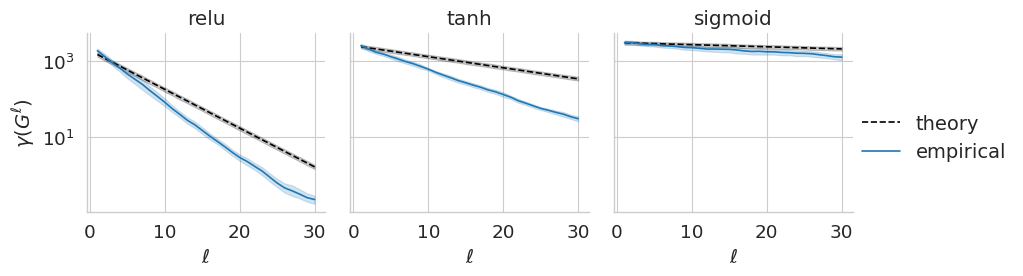

In [6]:


configs = dict(
    n = [10],
    d = [1000],
    L = [30],
    centering = ['layer'],
    normalization = ['layer'],
    activation_first = [True,],
    gain = [1.],
    bias = [0.],
    activation = ['relu','tanh','sigmoid',],
    degeneracy = [100],
    repeat = range(10),
)
df = run_experiments(configs)
df.head()


plot_line(data=df, y_var="gamma", col="activation", y_label="$\gamma(G^\ell)$", file_name='plots/gamma_vs_theory.pdf')


# plot_line(data=df, y_var="iso_gap", col="activation", y_label="$-\log\mathcal{I}(G^\ell)$", file_name='plots/isogap_vs_theory.pdf')


## Quantifying the influence of gain on isometry through non-linearity strength

100%|██████████| 90/90 [00:26<00:00,  3.40it/s]


<Figure size 640x480 with 0 Axes>

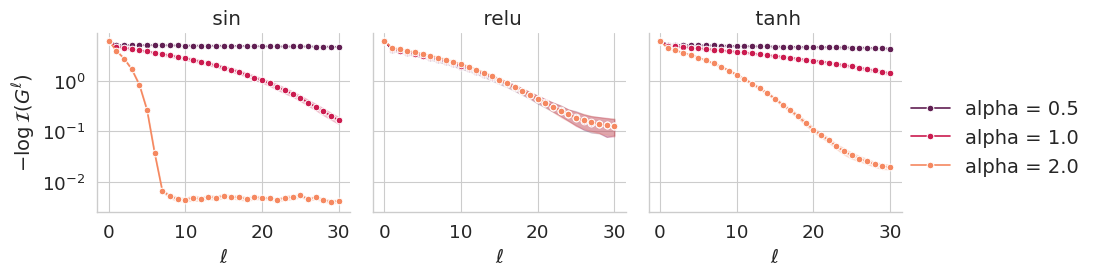

In [12]:

configs = dict(
    n = [10],
    d = [1000],
    L = [30],
    centering = ['layer'],
    normalization = ['layer'],
    activation_first = [True,],
    activation = ['sin','relu','tanh'],
    gain = [0.5,1.,2,],
    bias = [0.],
    degeneracy = [100],
    for_matrix=['G'],
    repeat = range(10),
)
df = run_experiments(configs)
df['alpha'] = df.apply(lambda x: f'alpha = {x.gain}', axis=1)
df.head()

plot_line_graph(df, y="iso_gap", y_label="$-\log\mathcal{I}(G^\ell)$",
                hue = "alpha", col="activation",#show_legend=False,
                palette="rocket",
                file_name='plots/gain_isometry.pdf', aspect=1)



<Figure size 640x480 with 0 Axes>

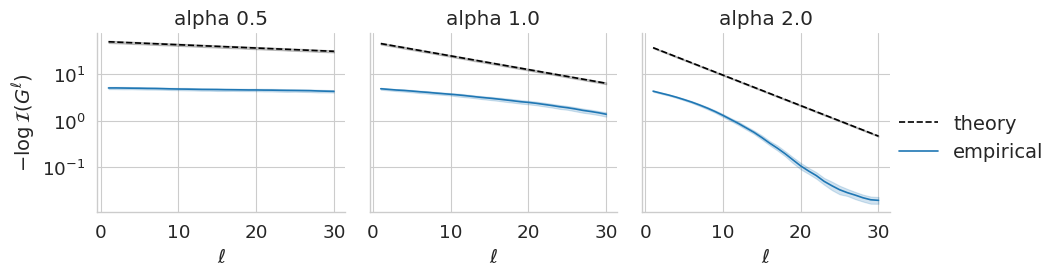

In [13]:


def act_gain_beta(F,gain):
    c0 = torch.mean(F(samples*gain)).item()
    c1 = torch.mean(F(samples*gain)*samples).item()
    csum2 = torch.mean(F(samples*gain)**2).item() 
    beta = 2 - c1**2 / (csum2 - c0**2)
    return beta

df['beta2'] = df.apply(lambda x: act_gain_beta(get_activation_function(x.activation),x.gain), axis=1)
df['iso_gap_theory'] = 10*df['iso_gap0'] / df.beta2 ** (df.l)
df['iso_gap_theory']
df['col'] = df.apply(lambda x: f'alpha {x.gain}',axis=1)

plot_line(data=df.loc[df.activation=='tanh'], 
          y_var="iso_gap", 
          col="col",height=3,aspect=1,
          y_label="$-\log\mathcal{I}(G^\ell)$", 
          file_name='plots/gain_iso_gap_pred.pdf')


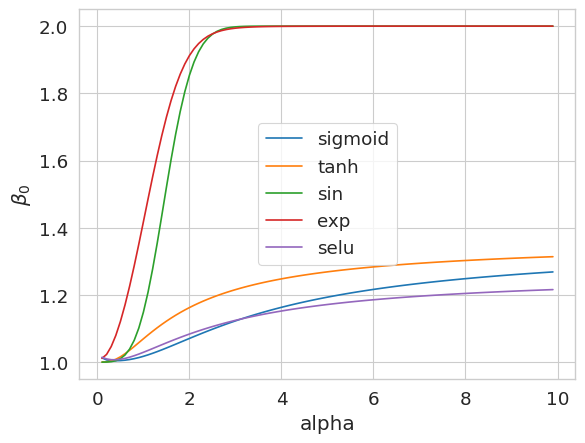

In [14]:
def act_beta(F,):
    c0 = torch.mean(F(samples)).item()
    c1 = torch.mean(F(samples)*samples).item()
    csum2 = torch.mean(F(samples)**2).item() 
    beta = 2 - c1**2 / (csum2 - c0**2)
    return beta

gs = torch.arange(.1,10,.1)
for act in ['sigmoid','tanh', 'sin','exp','selu']:
    f = get_activation_function(act)
    betas = []
    for g in gs:
        F = lambda x: f(x * g)
        beta = act_beta(F)
        betas.append(beta)
    plt.plot(gs, betas, label= act)
plt.xlabel('alpha')
plt.ylabel('$\\beta_0$')
plt.legend()
plt.savefig('plots/beta_vs_gain.pdf',bbox_inches="tight")
plt.show()

100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


<Figure size 640x480 with 0 Axes>

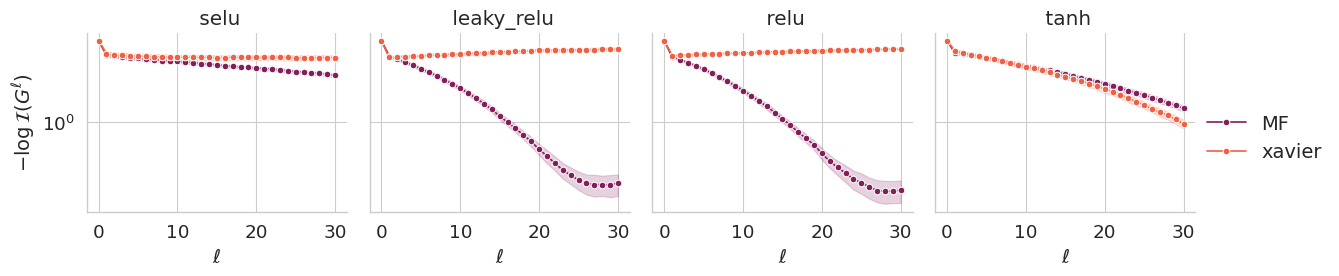

In [15]:

configs = dict(
    n = [10],
    d = [1000],
    L = [30],
    centering = ['MF'],
    normalization = ['MF'],
    activation_first = [True,],
    activation = ['selu','leaky_relu','relu','tanh',],
    gain = [1,],
    bias = [0.],
    degeneracy = [100],
    for_matrix=['G'],
    repeat = range(10),
)
df1 = run_experiments(configs)
configs = dict(
    n = [10],
    d = [1000],
    L = [30],
    centering = ['None'],
    normalization = ['None'],
    activation_first = [True,],
    activation = ['selu','leaky_relu','relu','tanh',],
    gain = ['xavier',],
    bias = [0.],
    degeneracy = [100],
    for_matrix=['G'],
    repeat = range(10),
)
df2 = run_experiments(configs)
df = pd.concat([df1,df2],axis=0)
df['method'] = df.apply(lambda x: 'xavier' if x.gain=='xavier' else 'MF', axis=1)
# df.head()

plot_line_graph(df, y="iso_gap", y_label="$-\log\mathcal{I}(G^\ell)$",
                hue = "method", col="activation",#show_legend=False,
                palette="rocket",
                file_name='plots/MF_vs_xavier.pdf', aspect=1)

